  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


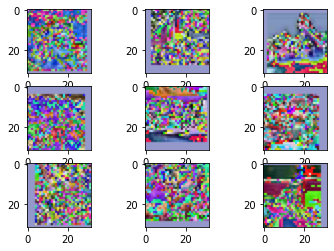

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
    T.ToPILImage()
])
#CIFAR-10 데이터셋 불러오기
training_data = CIFAR10(
    root="./",
    train=True,
    download = True,
    transform = transforms)

test_data = CIFAR10(
    root="./",
    train=False,
    download = True,
    transform = transforms)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(transforms(training_data.data[i]))
plt.show()

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 128

# Architecture
num_features = 784
num_classes = 10


Device: cuda:0


In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dim):
    super(BasicBlock, self).__init__()
    #nn.Module 클래스의 요소 상속

    #합성곱층 정의
    self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                           3, padding=1)
    self.bn1 = nn.BatchNorm2d(hidden_dim)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                           3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.pool(x)

    return x


    


In [ ]:
import torch
import torch.nn as nn

class NextBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dim):
    super(NextBlock, self).__init__()
    #nn.Module 클래스의 요소 상속

    #합성곱층 정의
    self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                           3, padding=1)
    self.bn1 = nn.BatchNorm2d(hidden_dim)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                           3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU()



  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)


    return x

In [ ]:
# class FinalBlock(nn.Module):
#   def __init__(self, in_channels, out_channels):
#     super(FinalBlock, self).__init__()
#     #nn.Module 클래스의 요소 상속

#     #합성곱층 정의
#     self.conv = nn.Conv2d(in_channels, out_channels,
#                            3, padding=1)
#     self.bn = nn.BatchNorm2d(out_channels)
#     self.relu = nn.ReLU()

#     self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#   def forward(self, x):
#     x = self.conv(x)
#     x = self.bn(x)
#     x = self.relu(x)

#     return x


In [ ]:
class VGG(nn.Module):
  def __init__(self, num_classes):
    super(VGG, self).__init__()

    #합성곱의 기본 블록 정의하기
    self.block1 = BasicBlock(in_channels=3,out_channels=64, hidden_dim=64)
    self.block2 = BasicBlock(in_channels=64,out_channels=128, hidden_dim=128)
    self.block3 = NextBlock(in_channels=128,out_channels=256, hidden_dim=256)
    self.block4 = BasicBlock(in_channels=256,out_channels=256, hidden_dim=256)
    self.block5 = NextBlock(in_channels=256,out_channels=512, hidden_dim=512)
    self.block6 = BasicBlock(in_channels=512,out_channels=512, hidden_dim=512)
    self.block7 = NextBlock(in_channels=512,out_channels=512, hidden_dim=512)
    self.block8 = BasicBlock(in_channels=512,out_channels=512, hidden_dim=512)
    

  #분류기 정의하기
    self.fc1 = nn.Linear(in_features= 512,out_features=1000)
    self.fc2 = nn.Linear(in_features=1000,out_features= 500)
    self.fc3 = nn.Linear(in_features=500,out_features=num_classes)

    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
    self.dropout = nn.Dropout(0.2)



  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)
    x = self.block8(x)
  
    x = torch.flatten(x, start_dim=1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)
    logits = x
    probas = F.softmax(logits, dim=1)

    return logits, probas


In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])


In [ ]:
#CIFAR-10 데이터셋 불러오기
training_data = CIFAR10(
    root="./",
    train=True,
    download = True,
    transform = transforms)

test_data = CIFAR10(
    root="./",
    train=False,
    download = True,
    transform = transforms)

train_loader = DataLoader(training_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)



    
torch.manual_seed(random_seed)
model = VGG(num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
lr = 0.001
optim = Adam(model.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0) #전체 사이즈로 나눠주기 위해 총 개수 계산
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader): #에폭마다 loss값을 계산(자세히 보기 위함)
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### 순전파 & 역전파 진행
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets) #F 사용해보기
        optimizer.zero_grad()
        
        cost.backward() #cross_entropy에 대한 backward 진행
        
        ### 모델 파라미터 업데이터
        optimizer.step()
        
        ### Loding
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/0500 | Cost: 2.3301
Epoch: 001/020 | Batch 0050/0500 | Cost: 1.9873
Epoch: 001/020 | Batch 0100/0500 | Cost: 1.9748
Epoch: 001/020 | Batch 0150/0500 | Cost: 1.9581
Epoch: 001/020 | Batch 0200/0500 | Cost: 1.9742
Epoch: 001/020 | Batch 0250/0500 | Cost: 1.9401
Epoch: 001/020 | Batch 0300/0500 | Cost: 1.9158
Epoch: 001/020 | Batch 0350/0500 | Cost: 1.8579
Epoch: 001/020 | Batch 0400/0500 | Cost: 1.8783
Epoch: 001/020 | Batch 0450/0500 | Cost: 1.8481
Epoch: 001/020 | Train: 28.094% | Loss: 2.006
Time elapsed: 1.37 min
Epoch: 002/020 | Batch 0000/0500 | Cost: 1.7996
Epoch: 002/020 | Batch 0050/0500 | Cost: 1.7583
Epoch: 002/020 | Batch 0100/0500 | Cost: 1.6010
Epoch: 002/020 | Batch 0150/0500 | Cost: 1.6654
Epoch: 002/020 | Batch 0200/0500 | Cost: 1.6685
Epoch: 002/020 | Batch 0250/0500 | Cost: 1.5868
Epoch: 002/020 | Batch 0300/0500 | Cost: 1.4956
Epoch: 002/020 | Batch 0350/0500 | Cost: 1.4533
Epoch: 002/020 | Batch 0400/0500 | Cost: 1.4059
Epoch: 002/020 | Ba

In [ ]:
# from tqdm import tqdm  # Progress Bar 출력

# def model_train(model, data_loader, loss_fn, optimizer, device):
#     model.train()
    
#     running_loss = 0
#     corr = 0
    
#     prograss_bar = tqdm(data_loader)
    
#     # mini-batch 학습을 시작
#     for data, label in prograss_bar:
 
#         data, label = data.to(device), label.to(device)
        
  
#         optimizer.zero_grad()
        
      
#         output = model(data)
        
       
#         loss = loss_fn(output, label)
        
        
#         loss.backward()
        
       
#         optimizer.step()
        
      
       
#         _, pred = output.max(dim=1)
        
     
#         corr += pred.eq(label).sum().item()
        
      
#         running_loss += loss.item() * data.size(0)
        
  
#     acc = corr / len(data_loader.dataset)
    
#     return running_loss / len(data_loader.dataset), acc

In [ ]:
# def model_evaluate(model, data_loader, loss_fn, device):
   
#     model.eval()
    
   
#     with torch.no_grad():
     
#         corr = 0
#         running_loss = 0
       
#         for data, label in data_loader:
          
#             data, label = data.to(device), label.to(device)
            
         
#             output = model(data)
            
       
#             _, pred = output.max(dim=1)
          
#             corr += torch.sum(pred.eq(label)).item()
            
         
#             running_loss += loss_fn(output, label).item() * data.size(0)
        
     
#         acc = corr / len(data_loader.dataset)
        
     
#         return running_loss / len(data_loader.dataset), acc

In [ ]:
# # 최대 Epoch을 지정합니다.
# import numpy as np
# num_epochs = 10
# model_name = 'vgg19-train'


# min_loss = np.inf

# # Epoch 별 훈련 및 검증을 수행한다
# for epoch in range(num_epochs):
#     # Model Training
#     # 훈련 손실과 정확도를 반환
#     train_loss, train_acc = model_train(model, train_loader, loss_fn, optim, device)

#     # 검증 손실과 검증 정확도를 반환
#     val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
#     # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치를 저장
#     if val_loss < min_loss:
#         print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
#         min_loss = val_loss
#         torch.save(model.state_dict(), f'{model_name}.pth')
    
#     # Epoch 별 결과를 출력하기
#     print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

In [ ]:
#모델 학습하기
# from tqdm import tqdm
# progress_bar = tqdm(train_loader)
# lr = 0.001
# optim = Adam(model.parameters(), lr=lr)

# for epoch in range(10):
#   for data, label in progress_bar:
#     optim.zero_grad() # 기울기 초기화

#     preds = model(data.to(device)) #모델의 예측

#     #오차역전파와 최적화 진행
#     loss = nn.CrossEntropyLoss()(preds, label.to(device))
#     loss.backward()
#     optim.step()

#   if epoch==0 or epoch%10==9:
#     print(f'epoch {epoch+1:02d}, loss: {loss:.5f}')


# torch.save(model.state_dict(), "CIFAR.pth")

In [ ]:


start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(test_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(test_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, test_loader),
              compute_epoch_loss(model, test_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/0100 | Cost: 0.3617
Epoch: 001/020 | Batch 0050/0100 | Cost: 0.4303
Epoch: 001/020 | Train: 87.350% | Loss: 0.399
Time elapsed: 0.29 min
Epoch: 002/020 | Batch 0000/0100 | Cost: 0.3138
Epoch: 002/020 | Batch 0050/0100 | Cost: 0.3492
Epoch: 002/020 | Train: 89.320% | Loss: 0.331
Time elapsed: 0.55 min
Epoch: 003/020 | Batch 0000/0100 | Cost: 0.2932
Epoch: 003/020 | Batch 0050/0100 | Cost: 0.2875
Epoch: 003/020 | Train: 90.310% | Loss: 0.311
Time elapsed: 0.83 min
Epoch: 004/020 | Batch 0000/0100 | Cost: 0.2465
Epoch: 004/020 | Batch 0050/0100 | Cost: 0.1704
Epoch: 004/020 | Train: 90.440% | Loss: 0.313
Time elapsed: 1.13 min
Epoch: 005/020 | Batch 0000/0100 | Cost: 0.2164
Epoch: 005/020 | Batch 0050/0100 | Cost: 0.1857
Epoch: 005/020 | Train: 90.660% | Loss: 0.298
Time elapsed: 1.40 min
Epoch: 006/020 | Batch 0000/0100 | Cost: 0.2803
Epoch: 006/020 | Batch 0050/0100 | Cost: 0.2595
Epoch: 006/020 | Train: 90.580% | Loss: 0.291
Time elapsed: 1.68 min
Epoch: 007

In [ ]:
import numpy as np
model_name = 'vgg19-train'
torch.save(model.state_dict(), f'{model_name}.pth')
model.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

In [ ]:
final_loss = compute_epoch_loss(model, test_loader)
final_acc = compute_accuracy(model, test_loader)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.12973, evaluation accuracy: 95.89000
